# DCGAN on Bricks Dataset

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/04_gan/01_dcgan/dcgan.ipynb), Lincense: Apache-2.0
- Dataset: [Kaggle](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images)

**This JAX/FLAX implementation also references [`bilal2vec`](https://github.com/bilal2vec)'s notebook -> [Link](https://github.com/bilal2vec/jax-dcgan)**

## NOTE: This notebook is still in progress, there're many bugs here

In [1]:
import numpy as np
import time
from collections import defaultdict
from IPython import display

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import metrics as Metrics

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.training import train_state

import optax
from clu import metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 100
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4

## 1. Prepare dataset

In [3]:
# Convert images to tensors normalize them
def preprocess(img):
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

# Load lego dataset from directory
def get_dataset():
    train_ds = utils.image_dataset_from_directory(
        directory=DATA_DIR,
        labels=None,
        color_mode='grayscale',
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=None,
        shuffle=True,
        seed=1024,
        interpolation='bilinear',
    ) 

    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(EPOCHS).shuffle(1024)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

    return train_ds

In [4]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i], cmap='gray')
        ax.axis('off')
    plt.show()

# plot training records
def show_records(history):
    plt.figure(figsize=(16, 3))
    for i, key in enumerate(history):
        ax = plt.subplot(1, len(history), i+1)
        ax.plot(history[key])
        ax.set_title(key)
    plt.show()

Found 40000 files belonging to 1 classes.
(128, 64, 64, 1)


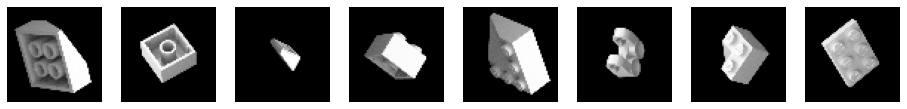

In [5]:
check_ds = get_dataset()
check_sample = next(iter(check_ds))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [6]:
class Discriminator(nn.Module):

    channel_list: tuple = (64, 128, 256, 512)
    
    @nn.compact
    def __call__(self, x, train:bool):

        # Convolutional layers
        for i, features in enumerate(self.channel_list):
            x = self.conv_block(x, features, i, train)

        # Output layers
        x = nn.Conv(features=1, kernel_size=(4, 4), strides=1, 
                    padding='valid', use_bias=False)(x)
        x = nn.sigmoid(x)
        x = x.reshape(-1, 1)
        return x

    # Downsampling convolution block
    def conv_block(self, x, out_features, use_bn, train:bool):
        x = nn.Conv(features=out_features, kernel_size=(4, 4), strides=2,
                    padding='same', use_bias=False)(x)
        
        if use_bn:
            x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        return x

net_D = Discriminator()
print(net_D.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 64, 64, 1)), train=False, console_kwargs={'width': 100}))


                                       Discriminator Summary                                        
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path        ┃ module        ┃ inputs         ┃ outputs        ┃ params         ┃ batch_stats     ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│             │ Discriminator │ -              │ float32[1,1]   │                │                 │
│             │               │ float32[1,64,… │                │                │                 │
│             │               │ - train: False │                │                │                 │
├─────────────┼───────────────┼────────────────┼────────────────┼────────────────┼─────────────────┤
│ Conv_0      │ Conv          │ float32[1,64,… │ float32[1,32,… │ kernel:        │                 │
│             │               │                │                │ float32[4,4,1… │        

In [7]:
class Generator(nn.Module):
    z_dim: int
    channel_list:tuple = (512, 256, 128, 64)

    @nn.compact
    def __call__(self, x, train:bool):
        x = x.reshape(x.shape[0], 1, 1, x.shape[1])

        # Transpose convolution layers
        for i, features in enumerate(self.channel_list):
            strides = 2 if i else 1
            padding = 'SAME' if i else 'VALID'
            x = self.transconv_block(x, features, strides, padding, train)

        # Output layers
        x = nn.ConvTranspose(features=CHANNELS, kernel_size=(4, 4), strides=(2, 2),
                             padding='SAME', use_bias=False)(x)
        x = nn.tanh(x)
        return x
        

    def transconv_block(self, x, out_features, strides, padding:str, train:bool):
        x = nn.ConvTranspose(features=out_features, kernel_size=(4, 4), strides=(strides, strides),
                             padding=padding, use_bias=False)(x)
        x = nn.BatchNorm(use_running_average=not train, momentum=0.9)(x)
        x = nn.leaky_relu(x, negative_slope=0.2)
        return x

netG = Generator(Z_DIM)
print(netG.tabulate(jax.random.PRNGKey(0), jnp.ones((1, Z_DIM)), train=False, console_kwargs={'width': 100}))


                                         Generator Summary                                          
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module        ┃ inputs        ┃ outputs        ┃ params        ┃ batch_stats    ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ Generator     │ -             │ float32[1,64,… │               │                │
│                │               │ float32[1,10… │                │               │                │
│                │               │ - train:      │                │               │                │
│                │               │ False         │                │               │                │
├────────────────┼───────────────┼───────────────┼────────────────┼───────────────┼────────────────┤
│ ConvTranspose… │ ConvTranspose │ float32[1,1,… │ float32[1,4,4… │ kernel:       │       

## 3. `Train State`

In [8]:
from typing import Any

# adding batch_stats and dropout keys to the properities of the class
class TrainState(train_state.TrainState):
    batch_stats: Any # for batch normalization layers
    key: jax.random.KeyArray = None # for dropout layers


# funtion to create a train state for modules
def create_train_state(module, init_array, 
                       params_key, dropout_key, 
                       learning_rate, train=False):
    """
    module: flax module
    init_array: jax.numpy.ones(shape=module_input_shape)
    param_key, dropout_key: jax.random.PRNGkey(0)
    """

    # Initialize the model with initialization array
    variables = module.init(params_key, init_array, train=False)
    params = variables['params']
    batch_stats = variables['batch_stats']

    # Create an optimizer
    tx = optax.adam(learning_rate=learning_rate, b1=ADAM_BETA_1, b2=ADAM_BETA_2)

    return TrainState.create(
            apply_fn=module.apply,
            params=params,
            batch_stats=batch_stats,
            key=dropout_key,
            tx=tx
            )

## 4. Loss functions

In [9]:
@jax.vmap
def bce_loss(logit, label):
    return jnp.maximum(logit, 0) - logit * label + jnp.log(1 + jnp.exp(-jnp.abs(logit)))

# Loss function for generator
def g_loss_fn(g_state, d_state, real_imgs, rng):
    
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    fake_imgs, g_variables = g_state.apply_fn(
                                {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                                latents,
                                train=True,
                                mutable=['batch_stats'])

    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    fake_preds, d_variables = d_state.apply_fn(
                                {'params': d_state.params, 'batch_stats': d_state.batch_stats},
                                fake_imgs,
                                train=True,
                                rngs={'dropout': dropout_train_key},
                                mutable=['batch_stats'])

    real_labels = jnp.ones(shape=(BATCH_SIZE,), dtype=jnp.int32)
    g_loss = bce_loss(fake_preds.reshape(-1, ), real_labels).mean()
    return g_loss, (g_variables, d_variables)


# Loss function for discriminator
def d_loss_fn(g_state, d_state, real_imgs, rng):
    
    # generate fake images
    latents = jax.random.normal(rng, shape=(BATCH_SIZE, Z_DIM))
    fake_imgs, g_variables = g_state.apply_fn(
                            {'params': g_state.params, 'batch_stats': g_state.batch_stats},
                            latents,
                            train=True,
                            mutable=['batch_stats'])

    # get discriminator's preds on real images
    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    real_preds, d_variables = d_state.apply_fn(
                            {'params': d_state.params, 'batch_stats': d_state.batch_stats},
                            real_imgs,
                            train=True,
                            rngs={'dropout': dropout_train_key},
                            mutable=['batch_stats'])

    # get discriminator's preds on fake images
    dropout_train_key = jax.random.fold_in(key=d_state.key, data=d_state.step)
    fake_preds, d_variables = d_state.apply_fn(
                            {'params': d_state.params, 'batch_stats': d_state.batch_stats},
                            fake_imgs,
                            train=True,
                            rngs={'dropout': dropout_train_key},
                            mutable=['batch_stats'])

    # create real and fake labels
    key_1, key_2 = jnp.random.split(rng)
    real_labels = jnp.ones_like(real_preds, dtype=jnp.int32)
    real_labels_noisy = real_labels + NOISE_PARAM * jax.random.normal(key_1, shape=real_labels.shape)
    fake_labels = jnp.zeros_like(fake_preds, dtype=jnp.int32)
    fake_labels_noisy = fake_labels - NOISE_PARAM * jax.random.normal(key_2, shape=fake_labels.shape)

    # Compute losses
    real_loss = bce_loss(real_preds.reshape(-1,), real_labels_noisy.reshape(-1,))
    fake_loss = bce_loss(fake_preds.reshape(-1,), fake_labels_noisy.reshape(-1,))
    loss = (real_loss + fake_loss).mean()
    return loss, (g_variables, d_variables)

## 5. Train step function

In [10]:
@jax.jit
def train_step(rng, g_state, d_state, real_imgs):
    rng, rng_g, rng_d = jax.random.split(rng)

    # create gradient functions
    g_grad_fn = jax.value_and_grad(g_loss_fn, has_aux=True)
    d_grad_fn = jax.value_and_grad(d_loss_fn, has_aux=True)

    # update generator
    (g_loss, (g_variables, d_variables)), g_grads = g_grad_fn(g_state, d_state, real_imgs, rng_g)
    g_state = g_state.apply_gradients(grads=g_grads)
    g_state = g_state.replace(batch_stats=g_variables['batch_stats'])

    # update discriminator
    (d_loss, (g_variables, d_variables)), d_grads = d_grad_fn(g_state, d_state, real_imgs, rng_d)
    d_state = d_state.apply_gradients(grads=d_grads)
    d_state = d_state.replace(batch_stats=d_variables['batch_stats'])

    return rng, g_state, d_state, g_loss, d_loss

## 6. Load datasets and create `train_stat`s

In [13]:
train_ds = get_dataset()

tf.random.set_seed(10)

rng = jax.random.PRNGKey(0)
d_param_key, g_param_key, dropout_key, rng = jax.random.split(key=rng, num=4)

g_net = Generator(Z_DIM)
d_net = Discriminator()

g_state = create_train_state(g_net, jnp.ones(shape=(1, Z_DIM)), g_param_key, None, LR)
d_state = create_train_state(d_net, jnp.ones(shape=(1, 64, 64, 1)), d_param_key, dropout_key, LR)

Found 40000 files belonging to 1 classes.
